<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data co

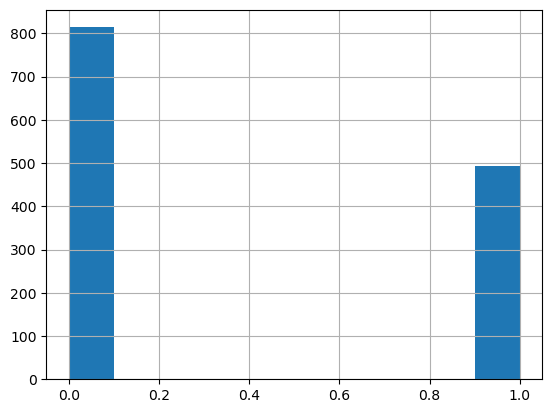

count    1308.000000
mean        2.294343
std         0.837929
min         1.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         3.000000
Name: Pclass, dtype: float64


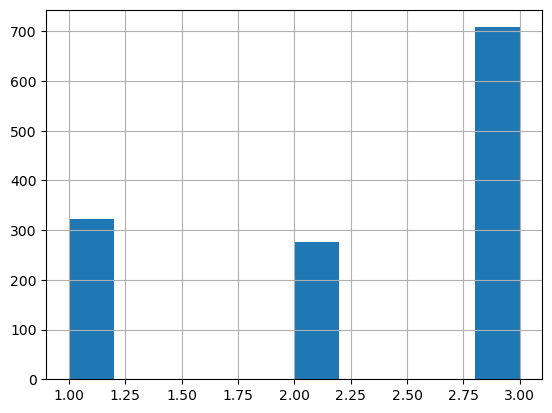

count    1308.000000
mean       29.851837
std        12.860236
min         0.170000
25%        22.000000
50%        29.851837
75%        35.000000
max        80.000000
Name: Age, dtype: float64


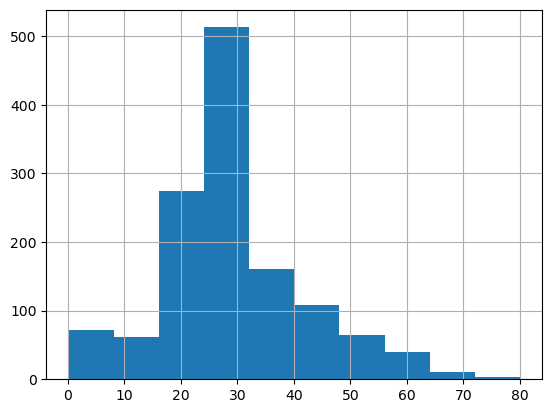

count    1308.000000
mean        0.499235
std         1.041965
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         8.000000
Name: SibSp, dtype: float64


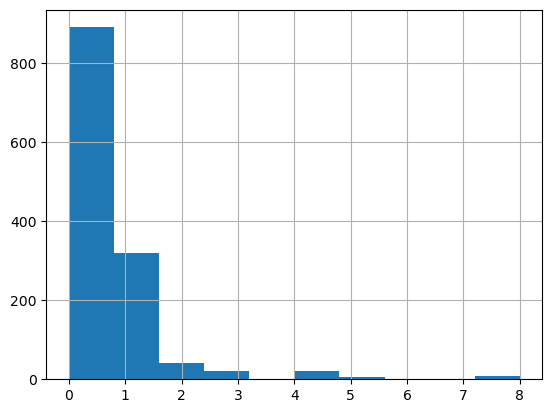

count    1308.000000
mean        0.385321
std         0.865826
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         9.000000
Name: Parch, dtype: float64


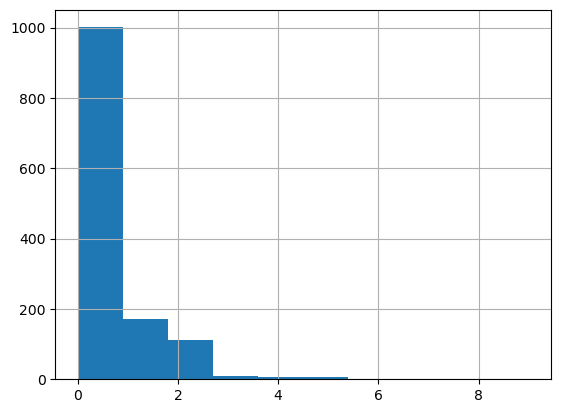

count    1308.000000
mean       33.295479
std        51.758668
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64


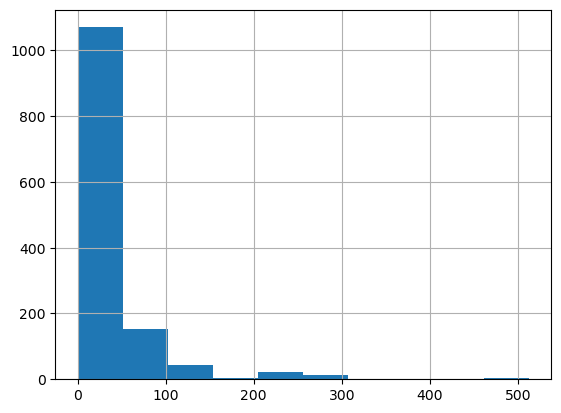

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


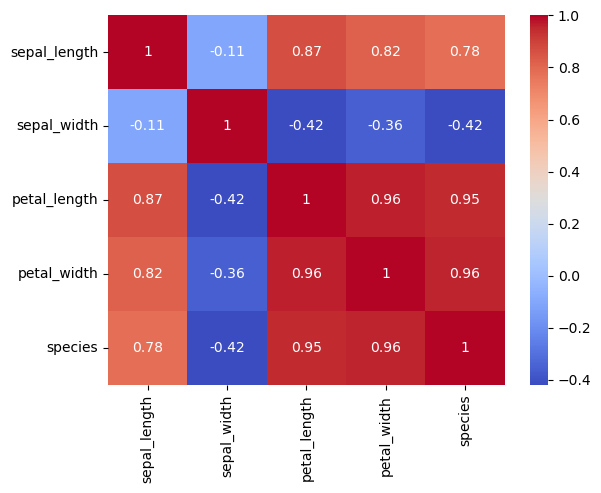

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
titanic=sns.load_dataset("titanic")
titanic.info()
#titanic.dropna()
titanic["age"]=titanic["age"].fillna(titanic["age"].mean(numeric_only=True))
#titanic.fillna(titanic.median(numeric_only=True))
titanic["embarked"]=titanic["embarked"].fillna(method="bfill") #следующий
titanic["deck"]=titanic["deck"].fillna(method="ffill") #предыдущий
#titanic["deck"]=titanic["deck"].fillna(method="bfill")
titanic.iloc[0, 11] = "B"
titanic["embark_town"] = titanic["embark_town"].fillna(method="ffill")
titanic.info()
titanic
#2
titanic_passengers = pd.read_csv("D:\IDA\lab_2_1_titanic\\train.csv")
titanic_passengers_info = pd.read_csv("D:\IDA\lab_2_1_titanic\\test.csv")
titanic_passengers_survived = pd.read_csv("D:\IDA\lab_2_1_titanic\\gender_submission.csv")
titanic_passengers = pd.DataFrame(titanic_passengers)
titanic_passengers_info = pd.DataFrame(titanic_passengers_info)
titanic_passengers_survived = pd.DataFrame(titanic_passengers_survived)

titanic_passengers_info = pd.merge(titanic_passengers_info, titanic_passengers_survived, on="PassengerId")
titanic_passengers_info.index = titanic_passengers_info["PassengerId"]
titanic_passengers_info = titanic_passengers_info.drop(["PassengerId"], axis = 1)

titanic_passengers.index = titanic_passengers["PassengerId"]
titanic_passengers = titanic_passengers.drop(["PassengerId"], axis = 1)
columns_order = ["Survived", "Pclass", "Name", "Sex", "Age", "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked"]
titanic_passengers_info = titanic_passengers_info.reindex(columns = columns_order)
titanic_passengers = pd.concat([titanic_passengers, titanic_passengers_info], axis = 0)
# Пример обнаружения аномалий в столбце "возраст" с использованием расстояния от среднего
titanic_passengers=titanic_passengers.dropna(subset="Fare")
def detect_outliers_mean(data):
    mean = np.mean(data)
    std = np.std(data)
    outliers = titanic_passengers[(data - mean).abs() > 3 * std]
    titanic_passengers
    return outliers
outliers_age = detect_outliers_mean(titanic_passengers["Age"])
outliers_fare = detect_outliers_mean(titanic_passengers["Fare"])
outliers_age
outliers_fare

# Пример обнаружения аномалий в столбце "возраст" с использованием z-оценки
def detect_outliers_z_score(column):
    # Вычисление среднего значения и стандартного отклонения
    mean = np.mean(column)
    std_dev = np.std(column)
    # Установка порогового значения
    threshold = 3
    # Идентификация аномалий
    anomalies = titanic_passengers[abs((column - mean) / std_dev) > threshold]
    return anomalies
anomalies = detect_outliers_z_score(titanic_passengers["Age"])
anomalies = detect_outliers_z_score(titanic_passengers["Fare"])




# Пример обнаружения аномалий в столбце "возраст" с использованием DBSCAN
def detect_outliers_dbscan(data, column, eps=0.1, min_samples=10):
    X = data[column].values.reshape(-1, 1)
    X_scaled = StandardScaler().fit_transform(X)
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(X_scaled)
    outliers = data[dbscan.labels_ == -1]
    return outliers
titanic_passengers["Age"]=titanic_passengers["Age"].fillna(titanic_passengers["Age"].mean(numeric_only=True))
outliers = detect_outliers_dbscan(titanic_passengers, "Age")
outliers


outliers_f = detect_outliers_dbscan(titanic_passengers, "Fare")
outliers_f

# outliers_fare
# anomalies

def detect_outliers_k_means(df, column, n_clusters=3):
    data = np.array(df[column]).reshape(-1, 1)
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(data)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    distances = np.min(np.abs(data - centroids[labels]), axis=1)
    threshold = np.std(distances) * 5
    anomaly_indices = np.where(distances > threshold)[0]
    anomalies = df.iloc[anomaly_indices]
    return anomalies

outliers_k_means_age = detect_outliers_k_means(titanic_passengers, "Age")
outliers_k_means_age

#3

df_encoded = titanic_passengers.copy()
df_encoded = pd.get_dummies(df_encoded, columns=['Sex', 'Embarked'])

df_encoded

#4 
iris=load_iris()
X = iris.data
# Min-Max Scaling
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X)

# Z-score стандартизация
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Вывод значений после нормализации
print("Min-Max Scaling:")
print(X_minmax)

print("\nZ-score стандартизация:")
print(X_standardized)
iris

#5
titanic_passengers
for column in titanic_passengers.columns:
    if titanic_passengers[column].dtype!="object":
#         mean=titanic_passengers[column].mean()
#         median=titanic_passengers[column].median()
#         mode=titanic_passengers[column].mode()
#         std=titanic_passengers[column].std()   
#         print(mode)
        statistics = titanic_passengers[column].describe()
        print(statistics)
        titanic_passengers[column].hist()
        plt.show()
#6
iris=pd.read_csv("D:/IDA/IRIS.csv")
iris["species"], uniques = pd.factorize(iris["species"])
correlation = iris.corr()
sns.heatmap(correlation, annot=True, cmap="coolwarm")
iris
outliers_age
outliers_fare

In [2]:
titanic_passengers.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,1308.000000,1308.000000,1308.000000,1308.000000,1308.000000,1308.000000
mean,0.377676,2.294343,29.851837,0.499235,0.385321,33.295479
std,0.484991,0.837929,12.860236,1.041965,0.865826,51.758668
min,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.895800
50%,0.000000,3.000000,29.851837,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.275000
max,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200
